General Overview:
1. Understand the shape of the data
2. Data Cleaning
3. Data Exploration
4. Feature Enginerring
5. Data Preprocessing for Model
6. Basic Model Buiilding
7. Model Tuning
8. Ensemble Model Building
9. Results

### 1. Understand the shape of the data

In [111]:
import numpy as np
import pandas as pd
import re
import calendar

import seaborn as sns
import matplotlib.style as style


import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# grid: rgb(240,240,240)
# background: rgb(200,200,200)
style.use('fivethirtyeight')

In [112]:
#import required packages
#basics
import pandas as pd 
import numpy as np

#misc
import gc
import time
import warnings

#stats
# from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss

#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS, ImageColorGenerator
from PIL import Image
import matplotlib_venn as venn

#nlp
import string
import re    #for regex
import nltk
from nltk.corpus import stopwords # remove useless words or words that do not add value
from nltk.stem.lancaster import LancasterStemmer # Convert words to the infinitive form - very aggressive transformation.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   

In [113]:
train = pd.read_csv('../data/train.csv')
def getting_to_know(df, question=None):
    display(df.shape)
    display(df.columns)
    if question == 'y':
        display(df.head())
        display(df.tail())
    print('--------------------------END--------------------------------')
getting_to_know(train, 'y')

(159571, 8)

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


--------------------------END--------------------------------


In [114]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
id               159571 non-null object
comment_text     159571 non-null object
toxic            159571 non-null int64
severe_toxic     159571 non-null int64
obscene          159571 non-null int64
threat           159571 non-null int64
insult           159571 non-null int64
identity_hate    159571 non-null int64
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


Let's create two dataframes containing only and no toxic comments, respectively:

In [115]:
no_toxic_train = train[(train['toxic'] == 0)
   & (train['severe_toxic'] == 0)
   & (train['obscene'] == 0) 
   & (train['threat'] == 0) 
   & (train['insult'] == 0) 
   & (train['identity_hate'] == 0)]

toxic_train = train[(train['toxic'] == 1)
   | (train['severe_toxic'] == 1)
   | (train['obscene'] == 1) 
   | (train['threat'] == 1) 
   | (train['insult'] == 1) 
   | (train['identity_hate'] == 1)]

In [116]:
train.shape[0] == (no_toxic_train.shape[0] + toxic_train.shape[0])

True

Let's see some values

In [117]:
train['toxic'].value_counts()

0    144277
1     15294
Name: toxic, dtype: int64

Compute tabulation between `toxic` and the other features

In [118]:
pd.crosstab(train.toxic, [train.obscene, train.threat, train.insult, train.identity_hate])

obscene             0                                    1                     \
threat              0                    1               0                  1   
insult              0          1         0      1        0         1        0   
identity_hate       0    1     0    1    0  1   0  1     0   1     0    1   0   
toxic                                                                           
0              143346   54   301   28   22  0   3  0   317   3   181   18   2   
1                5707  139  1229  141  124  8  17  3  1916  41  4789  883  15   

obscene                 
threat                  
insult           1      
identity_hate    0   1  
toxic                   
0                2   0  
1              195  87

Compute tabulation between `severe_toxic` against the rest

In [119]:
pd.crosstab(train.severe_toxic, [train.obscene, train.threat, train.insult, train.identity_hate])

obscene             0                                    1                     \
threat              0                    1               0                  1   
insult              0          1         0      1        0         1        0   
identity_hate       0    1     0    1    0  1   0  1     0   1     0    1   0   
severe_toxic                                                                    
0              149012  190  1516  162  135  7  19  3  2075  38  3981  636  13   
1                  41    3    14    7   11  1   1  0   158   6   989  265   4   

obscene                 
threat                  
insult           1      
identity_hate    0   1  
severe_toxic            
0              133  56  
1               64  31

First three comments

In [120]:
[train['comment_text'][i] for i in range(3)] 

["Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",
 "D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)",
 "Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info."]

### 2. Data Cleaning 

In [121]:
stop = stopwords.words('english')
stop

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [122]:
def clean_data(df):

    # Lowercase letters
    df['comment_text'] = df['comment_text'].str.lower()
    
    # Remove special characters (i.e. @, $, %)
    df['comment_text'] = df['comment_text'].str.replace("[^a-z0-9!@#\$%\^\&\*_\-,\.' ]", " ") 
    
    # Remove punctuations - if you don't want to remove this, comment below out
    df['comment_text'] = df['comment_text'].str.replace('[^\w\s]', "")
    
    # Remove random numbers
    df['comment_text'] = df['comment_text'].str.replace("[^a-z' ]", "")
    
    # Remove repeating characters and extra spaces 
    # Examples: 'whaaat' --> 'what' OR 'hello   bye' --> 'hello bye'
    # Note: This does change words like "look" to "lok" cuz of the double letters, 
    # if we don't want this, we can remove the \w in the regex pattern below.
    repeat_pattern = re.compile(r'(\w|\s)\1*')
    match_substitution = r'\1'
    df['comment_text'] = df['comment_text'].apply(lambda x: repeat_pattern.sub(match_substitution, x))
    
    # Remove all numbers with letters
    alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)

    # '[%s]' % re.escape(string.punctuation),' ' - replace punctuation with white space
    # .lower() - convert all strings to lowercase 
    punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

    # Remove all '\n' in the string and replace it with a space
    remove_n = lambda x: re.sub("\n", " ", x)

    # Remove all non-ascii characters 
    remove_non_ascii = lambda x: re.sub(r'[^\x00-\x7f]',r' ', x)


    

    # Apply all the lambda functions wrote previously through .map on the comments column
    df['comment_text'] = df['comment_text'].map(alphanumeric).map(punc_lower).map(remove_n).map(remove_non_ascii)
    
    # Remove stop words
#     pattern = re.compile(r'\b('+stop_words_arr+r')\b', flags=re.IGNORECASE).apply(str)
#     remove_stop_words = lambda x: re.sub('\s+', ' ', re.sub(pattern, '', x))
#     pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
#     df['comment_text'] = pattern.sub('', str(df['comment_text']))
    df['comment_text_clean']= df['comment_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

    

    
    return df

In [ ]:
# test = pd.read_csv('../data/')
# test.shape

train = clean_data(train)

In [ ]:
[train['comment_text'][i] for i in range(3)] 

In [ ]:
[train['comment_text_clean'][i] for i in range(3)] 

In [13]:
test = pd.read_csv('../data/test.csv')
test = clean_data(test)


### 3. Data Exploration

In [15]:
train.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [16]:
train['toxic'].value_counts(normalize = True)

0    0.904156
1    0.095844
Name: toxic, dtype: float64

In [17]:
train['severe_toxic'].value_counts(normalize = True)

0    0.990004
1    0.009996
Name: severe_toxic, dtype: float64

In [18]:
train['obscene'].value_counts(normalize = True)

0    0.947052
1    0.052948
Name: obscene, dtype: float64

In [19]:
train['threat'].value_counts(normalize = True)

0    0.997004
1    0.002996
Name: threat, dtype: float64

In [20]:
train['insult'].value_counts(normalize = True)

0    0.950636
1    0.049364
Name: insult, dtype: float64

In [21]:
train['identity_hate'].value_counts(normalize = True)

0    0.991195
1    0.008805
Name: identity_hate, dtype: float64

In [22]:
count_comments = train.iloc[:, 2:].sum()
count_comments 

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

/Users/cristobalza/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


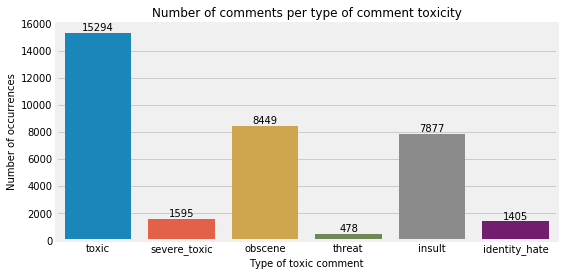

In [23]:
plt.figure(figsize = (8,4))

ax = sns.barplot(count_comments.index, count_comments.values, alpha = 1)

rects = ax.patches 
labels = count_comments.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha = 'center', va = 'bottom')
    
plt.title('Number of comments per type of comment toxicity', fontsize = 12)
plt.ylabel('Number of occurrences', fontsize = 10)
plt.xlabel('Type of toxic comment', fontsize = 10)

plt.show();

In [24]:
num_rows = len(train)
toxic_sum = train['toxic'].sum() / num_rows * 100
severe_toxic_sum = train['severe_toxic'].sum() / num_rows * 100
obscene_sum = train['obscene'].sum() / num_rows * 100
threat_sum = train['threat'].sum() / num_rows * 100
insult_sum = train['insult'].sum() / num_rows * 100
id_hate_sum = train['identity_hate'].sum() / num_rows * 100

In [25]:
toxic_features = ['toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate']

AttributeError: 'BarContainer' object has no attribute 'xaxis'

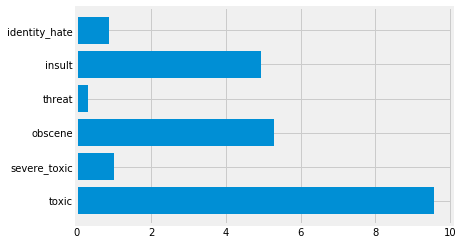

In [26]:
ax = plt.barh(
    toxic_features, [toxic_sum, severe_toxic_sum, obscene_sum, threat_sum, insult_sum, id_hate_sum] )
# # manipulate
# vals = ax.get_xticks()
# ax.set_xticklabels(['{:,.2%}'.format(x) for x in vals])
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))

Separate the dataset into 6 sections.

Each section is **a comment + a toxic category.**

In [27]:
toxic_df = train.loc[:,['id', 'comment_text', 'toxic']]
severe_toxic_df = train.loc[:,['id', 'comment_text', 'severe_toxic']]
obscene_df = train.loc[:,['id', 'comment_text', 'obscene']]
threat_df = train.loc[:,['id', 'comment_text', 'threat']]
insult_df = train.loc[:,['id', 'comment_text', 'insult']]
id_hate_df = train.loc[:,['id', 'comment_text', 'identity_hate']]

In [28]:
def word_cloud_func(df, category):
    '''
    WordCloud for specific toxic category
    '''
    temp = df[df[category] == 1]
    text = temp.comment_text.values
    wc = WordCloud(max_words=2000)
    
    wc.generate(" ".join(text))
    
    plt.figure(figsize=(20,20))
    

In [29]:
# word_cloud_func(toxic_df, 'toxic')

#### Data Analysis:

From above, we can see that the toxic features such that `toxic`, `severe_toxic`, `obscene`, `threat`,`insult`, `identity_hate` only make up to around $10\%$ on their respectively self subsets. **This can lead to a class imbalance issue later on.**

If we don't solve the issue of the toxic comment imbalance, then **our model will be strongly biased to the non-toxic comments**.

In order to deal with a class imbalance, we can take a subset of the data where the proportion of the toxic comments are at least 1/4 in relation to non-toxic comments.

Consider the count value of each toxic feature in terms of toxicity:

In [30]:
toxic_features = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']
toxic_val = [train[e].value_counts()[1] for e in toxic_features]
dict_toxic_value = {k:v for k,v in zip(toxic_features, toxic_val)}
dict_toxic_value

{'toxic': 15294,
 'severe_toxic': 1595,
 'obscene': 8449,
 'threat': 478,
 'insult': 7877,
 'identity_hate': 1405}

In [31]:
# Total number of toxic comment counted 
total_count = sum(dict_toxic_value.values())
total_count

35098

In [32]:
total_count / 6

5849.666666666667

So we will choose randomly a specific selection of rows depending on the number of positive toxic commnets each feature has. In other words, we will set the number of rows fixed but the choice of rows will be randomize.

Recall, that the number of rows will be kept fixed in order to decrease the non-toxic comment bias and we randomized the rows just to increase the variance of all possible comments that can be trained on.

We will set a threshold of numbers
- `toxic` : 5850
- `severe_toxic` : 1595
- `obscene` : 5850
- `threat` : 478*
- `insult` : 5850
- `identity_hate` : 1405*

\*: For `threat` since it the number of threat votes are too small (less than 20% of their partition), we will add up the rest using the leftover such that:

Then we proceed to balance the dataset.

In [33]:
toxic_df[toxic_df['toxic'] == 1].iloc[:5850, :].shape

(5850, 3)

In [34]:
toxic_1 = toxic_df[toxic_df['toxic'] == 1].sample(5850)
toxic_0 = toxic_df[toxic_df['toxic'] == 0].sample(5850)
data_toxic_balanced = pd.concat([toxic_1,toxic_0], axis = 0)

In [35]:
data_toxic_balanced.shape

(11700, 3)

In [36]:
data_toxic_balanced.head()

,id,comment_text,toxic
91743,f541910c43b27182,apears to be uncontructive since when do your ...,1
62939,a859c413543e1627,re justification for coment left which tok th...,1
18381,3083db7119ead614,dont use wikipedia hey im liz and i hate wikip...,1
83574,df9f2e814d450438,you are nothing more than a malignant cancer ...,1
7748,149e15ad2efded1a,u r so gay,1


In [37]:
severe_toxic_1 = severe_toxic_df[severe_toxic_df['severe_toxic'] == 1].iloc[:1595, :]
severe_toxic_0 = severe_toxic_df[severe_toxic_df['severe_toxic'] == 0].iloc[:1595, :]
data_severe_toxic_balanced = pd.concat([severe_toxic_1,severe_toxic_0], axis = 0)
data_severe_toxic_balanced.shape

(3190, 3)

In [38]:
obscene_1 = obscene_df[obscene_df['obscene'] == 1].iloc[:5850, :]
obscene_0 = obscene_df[obscene_df['obscene'] == 0].iloc[:5850, :]
data_obscene_balanced = pd.concat([obscene_1,obscene_0], axis = 0)
data_obscene_balanced.shape

(11700, 3)

In [39]:
threat_1 = threat_df[threat_df['threat'] == 1].iloc[:478, :]
threat_0 = obscene_df[obscene_df['obscene'] == 0].iloc[:5000, :]
data_obscene_balanced = pd.concat([obscene_1,obscene_0], axis = 0)
data_obscene_balanced.shape

(11700, 3)

##### Use `NearMiss`

In [40]:
# !pip install imblearn

In [57]:
# from imblearn.under_sampling  import NearMiss
# from collections import Counter

# nm = NearMiss()

# train_res, test_res = nm.fit_sample(train, test)


In [43]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0
1,000103f0d9cfb60f,daw he matches this background colour im semin...,0,0,0,0,0,0
2,000113f07ec002fd,hey man im realy not trying to edit war its ju...,0,0,0,0,0,0
3,0001b41b1c6bb37e,more i cant make any real sugestions on impro...,0,0,0,0,0,0
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0


In [44]:
train_new = pd.read_csv('../data/train_original_new_column.csv')

In [45]:
train_new = clean_data(train_new)

In [50]:
clean_comments_df = train_new[train_new['final_toxicity'] == 0]

In [51]:
num_select = len(train_new[train_new['final_toxicity'] == 1])

In [52]:
clean_comments_df = clean_comments_df.sample(num_select)
clean_comments_df.shape

(16225, 9)

In [56]:
dirty_comments_df = train_new[train_new['final_toxicity'] == 1]
dirty_comments_df.shape

(16225, 9)

In [55]:
df_total = pd.concat([clean_comments_df, dirty_comments_df], axis=0)
df_total.shape

(32450, 9)

### 4. Feature Enginering

### 5. Data Preprocessing for Model


In [58]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/cristobalza/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Stopwords are a list of 'useless' words such that

array(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
       "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself',
       'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her',
       'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them',
       'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom',
       'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are',
       'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
       'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and',
       'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at',
       'by', 'for', 'with', 'about', 'against', 'between', 'into',
       'through', 'during', 'before', 'after', 'above', 'below', 'to',
       'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under',
       'again', 'further', 'then', 'once', 'here', 'there', 'when',
       'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'm

### 6. Basic Model Buiilding

F! Score

### 7. Model Tuning

### 8. Ensemble Model Building

### 9. Results & Deployment 